In [1]:
!pip install opencv-python

In [1]:
pip install numpy==1.26.4

Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
import numpy as np
import cv2
from sklearn.metrics import matthews_corrcoef
from tqdm import tqdm
import matplotlib.pyplot as plt

print("All imports are successful")

All imports are successful


In [5]:
# Defining the paths
pred_dir = "Predicted_simtex"
gt_dir = "annotated_img"

# Listing the image filenames
pred_files = sorted([f for f in os.listdir(pred_dir) if f.endswith(".tif") or f.endswith(".tiff")])
gt_files = sorted([f for f in os.listdir(gt_dir) if f.endswith(".tif") or f.endswith(".tiff")])

In [7]:
def strip_suffix(filename):
    base = filename

    # Remove known prefixes and suffixes
    for prefix in ['c_ftow_', 'c_ftow_pix_', 'pix_']:  # Add all possible prefixes
        if base.startswith(prefix):
            base = base.replace(prefix, '', 1)

    base = base.replace('_rsz', '')    # Remove resized suffix
    base = base.replace('_mask', '')   # Remove mask suffix

    # Normalize the file extension
    if base.endswith('.tiff'):
        base = base.replace('.tiff', '.tif')

    return base

In [29]:
# Creating the maps 
gt_map = {strip_suffix(f): f for f in gt_files}
pred_map = {strip_suffix(f): f for f in pred_files}

# Finding common file keys
common_keys = sorted(set(gt_map.keys()) & set(pred_map.keys()))

# Printing the number of matched files
print(f"\nTotal matched files: {len(common_keys)} out of {len(gt_files)} ground truth and {len(pred_files)} predicted")

print("\nSample matched filenames:")
for k in common_keys[:5]:
    print(f"GT → {gt_map[k]}  |  PR → {pred_map[k]}")


Total matched files: 28 out of 28 ground truth and 28 predicted

Sample matched filenames:
GT → c_ftow_pix_1_0_0wave_rsz_mask.tiff  |  PR → pix_1_0_0wave_rsz.tif
GT → c_ftow_pix_1_0_1wave_rsz_mask.tiff  |  PR → pix_1_0_1wave_rsz.tif
GT → c_ftow_pix_1_0_2wave_rsz_mask.tiff  |  PR → pix_1_0_2wave_rsz.tif
GT → c_ftow_pix_1_0_3wave_rsz_mask.tiff  |  PR → pix_1_0_3wave_rsz.tif
GT → c_ftow_pix_1_10_0wave_rsz_mask.tiff  |  PR → pix_1_10_0wave_rsz.tif


In [31]:
# Creating new maps from cleaned filenames
gt_map = {strip_suffix(f): f for f in gt_files}
pred_map = {strip_suffix(f): f for f in pred_files}

# Finding common keys
common_keys = sorted(set(gt_map.keys()) & set(pred_map.keys()))

# Building aligned full paths
aligned_gt = [os.path.join(gt_dir, gt_map[k]) for k in common_keys]
aligned_pred = [os.path.join(pred_dir, pred_map[k]) for k in common_keys]

# Checking sample
print(f"Total matched files: {len(common_keys)}")
print("Sample matched pairs:")
for k in common_keys[:3]:
    print(f"GT → {gt_map[k]}   |   PR → {pred_map[k]}")

Total matched files: 28
Sample matched pairs:
GT → c_ftow_pix_1_0_0wave_rsz_mask.tiff   |   PR → pix_1_0_0wave_rsz.tif
GT → c_ftow_pix_1_0_1wave_rsz_mask.tiff   |   PR → pix_1_0_1wave_rsz.tif
GT → c_ftow_pix_1_0_2wave_rsz_mask.tiff   |   PR → pix_1_0_2wave_rsz.tif


In [33]:
# Picking the first aligned pair
sample_gt_path = aligned_gt[0]
sample_pred_path = aligned_pred[0]

# Reading both images in grayscale
gt_img = cv2.imread(sample_gt_path, cv2.IMREAD_GRAYSCALE)
pred_img = cv2.imread(sample_pred_path, cv2.IMREAD_GRAYSCALE)

# Printing their shapes
print("Ground Truth shape:", gt_img.shape)
print("Prediction shape:", pred_img.shape)

# Printing unique pixel values in both
print("GT unique pixel values:", np.unique(gt_img))
print("Pred unique pixel values:", np.unique(pred_img))

Ground Truth shape: (512, 512)
Prediction shape: (512, 512)
GT unique pixel values: [  0 255]
Pred unique pixel values: [  0 255]


In [17]:
print("Ground Truth unique values:", np.unique(gt_img))
print("Prediction unique values:", np.unique(pred_img))

Ground Truth unique values: [  0 255]
Prediction unique values: [  0 255]


In [19]:
gt_bin = (gt_img == 255).astype(np.uint8)
pred_bin = (pred_img == 255).astype(np.uint8)

print("Binary output successful.")
print("GT unique values after binarization:", np.unique(gt_bin))
print("PR unique values after binarization:", np.unique(pred_bin))

Binary output successful.
GT unique values after binarization: [0 1]
PR unique values after binarization: [0 1]


In [21]:
# Converting boolean to integers
gt_flat = gt_bin.flatten().astype(int)
pred_flat = pred_bin.flatten().astype(int)

# running MCC 
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(gt_flat, pred_flat)
print("MCC for this image pair:", mcc)

MCC for this image pair: 0.7969302559138343


In [23]:
from tqdm import tqdm

mcc_scores = []

In [25]:
for gt_path, pred_path in tqdm(zip(aligned_gt, aligned_pred), total=len(aligned_gt)):
    # Reading the images
    gt_img = cv2.imread(gt_path, cv2.IMREAD_GRAYSCALE)
    pred_img = cv2.imread(pred_path, cv2.IMREAD_GRAYSCALE)

    gt_bin = (gt_img == 255).astype(np.uint8)
    pred_bin = (pred_img == 255).astype(np.uint8)

    # Flattening the images for the MCC coefficient
    gt_flat = gt_bin.flatten().astype(int)
    pred_flat = pred_bin.flatten().astype(int)

    # Computing the MCC
    mcc = matthews_corrcoef(gt_flat, pred_flat)
    mcc_scores.append((os.path.basename(gt_path), mcc))

100%|███████████████████████████████████████████| 28/28 [00:00<00:00, 35.69it/s]


In [27]:
# Sorting by the MCC score
mcc_scores_sorted = sorted(mcc_scores, key=lambda x: x[1], reverse=True)

# Printing the top 5 best and worst
print("Top 5 highest MCC scores:")
for name, score in mcc_scores_sorted[:5]:
    print(f"{name}: {score:.4f}")

print("\nBottom 5 lowest MCC scores:")
for name, score in mcc_scores_sorted[-5:]:
    print(f"{name}: {score:.4f}")

Top 5 highest MCC scores:
c_ftow_pix_1_45_0wave_rsz_mask.tiff: 0.9683
c_ftow_pix_1_30_0wave_rsz_mask.tiff: 0.9658
c_ftow_pix_1_45_1wave_rsz_mask.tiff: 0.9619
c_ftow_pix_1_30_3wave_rsz_mask.tiff: 0.9564
c_ftow_pix_1_45_3wave_rsz_mask.tiff: 0.9550

Bottom 5 lowest MCC scores:
c_ftow_pix_1_5_3wave_rsz_mask.tiff: 0.9057
c_ftow_pix_1_2.5_0wave_rsz_mask.tiff: 0.9034
c_ftow_pix_1_5_0wave_rsz_mask.tiff: 0.8938
c_ftow_pix_1_10_0wave_rsz_mask.tiff: 0.8845
c_ftow_pix_1_0_0wave_rsz_mask.tiff: 0.7969


/var/folders/t0/cg3zdgw11kbccwbtk4jlmvmh0000gn/T/ipykernel_57582/3339166956.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sorted_names, y=sorted_scores, palette="coolwarm", hue=None)


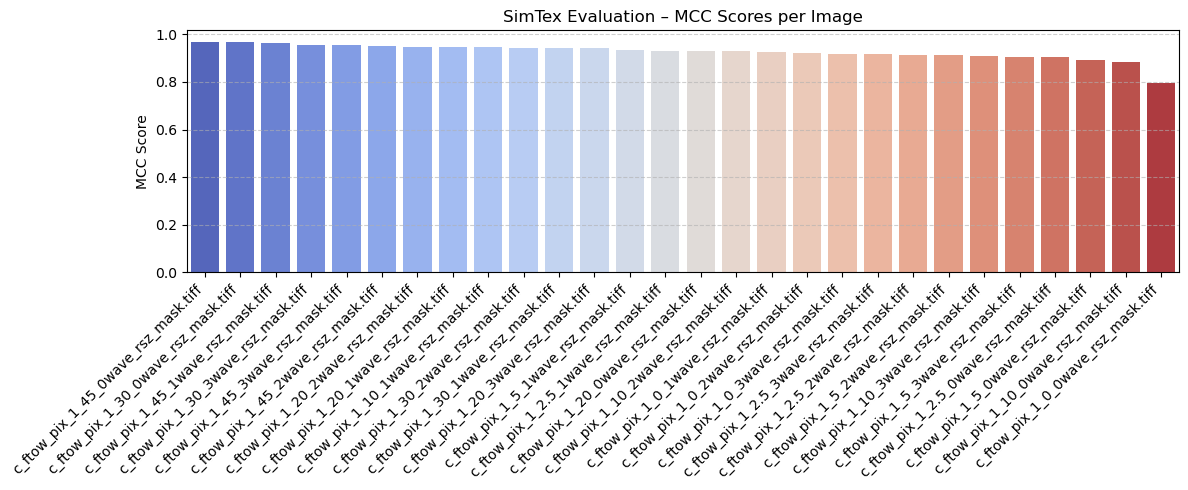

In [105]:
import seaborn as sns
import matplotlib.pyplot as plt

sorted_names = [name for name, _ in mcc_scores_sorted]
sorted_scores = [score for _, score in mcc_scores_sorted]

# Plotting
plt.figure(figsize=(12, 5))
sns.barplot(x=sorted_names, y=sorted_scores, palette="coolwarm", hue=None)

plt.xticks(rotation=45, ha='right')
plt.ylabel("MCC Score")
plt.title("SimTex Evaluation – MCC Scores per Image")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

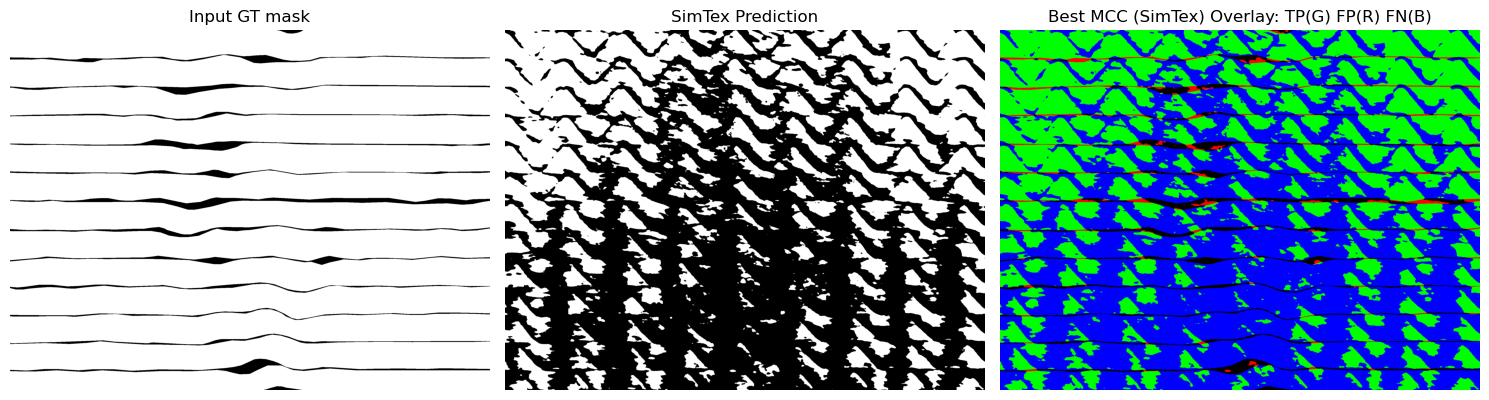

Visual overlay done: Best MCC (SimTex)


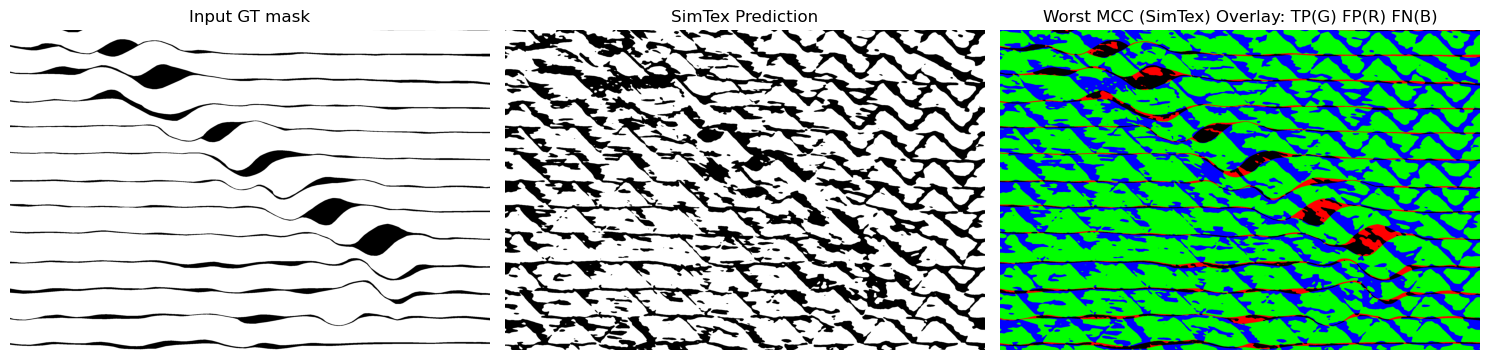

Visual overlay done: Worst MCC (SimTex)


In [115]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Function to plot overlay with TP (green), FP (red), FN (blue)
def plot_overlay(title, gt_path, pred_path):
    # Load both images
    gt_img = cv2.imread(gt_path, cv2.IMREAD_GRAYSCALE)
    pred_img = cv2.imread(pred_path, cv2.IMREAD_GRAYSCALE)

    # Error handling
    if gt_img is None:
        print(f"❌ GT image not found: {gt_path}")
    if pred_img is None:
        print(f"❌ Prediction image not found: {pred_path}")
    assert gt_img is not None and pred_img is not None, "One or both images could not be read."

    # Resize if needed
    if gt_img.shape != pred_img.shape:
        pred_img = cv2.resize(pred_img, (gt_img.shape[1], gt_img.shape[0]), interpolation=cv2.INTER_NEAREST)

    # Binarize
    _, gt_bin = cv2.threshold(gt_img, 128, 255, cv2.THRESH_BINARY)
    _, pred_bin = cv2.threshold(pred_img, 128, 255, cv2.THRESH_BINARY)

    # Make TP/FP/FN masks
    tp = np.logical_and(gt_bin == 255, pred_bin == 255)
    fp = np.logical_and(gt_bin == 0, pred_bin == 255)
    fn = np.logical_and(gt_bin == 255, pred_bin == 0)

    # Creating overlay
    overlay = np.zeros((*gt_bin.shape, 3), dtype=np.uint8)
    overlay[tp] = [0, 255, 0]     # Green = TP
    overlay[fp] = [255, 0, 0]     # Red = FP
    overlay[fn] = [0, 0, 255]     # Blue = FN

    # Plotting
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.title("Input GT mask")
    plt.imshow(gt_bin, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title("SimTex Prediction")
    plt.imshow(pred_bin, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title(f"{title} Overlay: TP(G) FP(R) FN(B)")
    plt.imshow(overlay)
    plt.axis('off')

    plt.tight_layout()
    plt.show()
    print(f"Visual overlay done: {title}")

best_index = 0          # Highest MCC
worst_index = -1        # Lowest MCC

best_gt_path = aligned_gt[best_index]
best_pred_path = aligned_pred[best_index]

worst_gt_path = aligned_gt[worst_index]
worst_pred_path = aligned_pred[worst_index]

plot_overlay("Best MCC (SimTex)", best_gt_path, best_pred_path)
plot_overlay("Worst MCC (SimTex)", worst_gt_path, worst_pred_path)

In [121]:
# Update folder paths for CJM evaluation
pred_dir = "NCF_CJM_SET/02. Tow"
gt_dir = "CJM Masks"

# Confirm that files are loading correctly
pred_files = sorted([f for f in os.listdir(pred_dir) if f.endswith(".tif") or f.endswith(".tiff")])
gt_files = sorted([f for f in os.listdir(gt_dir) if f.endswith(".tif") or f.endswith(".tiff")])

print(f"Predicted files: {len(pred_files)}")
print(f"Ground truth files: {len(gt_files)}")

Predicted files: 5
Ground truth files: 2


In [113]:
# Listing files with case-insensitive extension match
def is_tiff(filename):
    return filename.lower().endswith((".tif", ".tiff"))

pred_files = sorted([f for f in os.listdir(pred_dir) if is_tiff(f)])
gt_files = sorted([f for f in os.listdir(gt_dir) if is_tiff(f)])

print(f"Predicted files: {len(pred_files)}")
print(f"Ground truth files: {len(gt_files)}")

Predicted files: 5
Ground truth files: 5


In [43]:
# Defining a stem-cleaning function
def strip_suffix(filename):
    # Getting filename without extension
    base = os.path.splitext(filename)[0]
    # Removing any known prefixes/suffixes to get matching stems
    base = base.lower().replace("c_ftow_", "").replace("_mask", "").replace("gray_", "")
    return base

In [55]:
# Creating the stem-to-filename mappings
gt_map = {strip_suffix(f): f for f in gt_files}
pred_map = {strip_suffix(f): f for f in pred_files}

# Checking how many common filenames exist
common_keys = sorted(set(gt_map.keys()) & set(pred_map.keys()))
print(f"Total matched files: {len(common_keys)}")

# Previewing a few matched pairs
for k in common_keys[:3]:
    print(f"GT → {gt_map[k]}  |  PR → {pred_map[k]}")

Total matched files: 5
GT → c_ftow_gray_IMG_0100_mask.TIFF  |  PR → gray_IMG_0100.tif
GT → c_ftow_gray_IMG_0103_mask.TIFF  |  PR → gray_IMG_0103.tif
GT → c_ftow_gray_IMG_0116_mask.TIFF  |  PR → gray_IMG_0116.tif


In [57]:
# Building aligned full paths
aligned_gt = [os.path.join(gt_dir, gt_map[k]) for k in common_keys]
aligned_pred = [os.path.join(pred_dir, pred_map[k]) for k in common_keys]

# Printing some of the samples
print(f"Aligned GT sample → {aligned_gt[0]}")
print(f"Aligned PR sample → {aligned_pred[0]}")
print("Path alignment complete")

Aligned GT sample → CJM Masks/c_ftow_gray_IMG_0100_mask.TIFF
Aligned PR sample → NCF_CJM_SET/02. Tow/gray_IMG_0100.tif
Path alignment complete


In [59]:
# Computing the MCC for each CJM image pair
mcc_scores_cjm = []

for gt_path, pred_path in tqdm(zip(aligned_gt, aligned_pred), total=len(aligned_gt), desc="Computing MCC"):
    # Loading both images in grayscale
    gt_img = cv2.imread(gt_path, cv2.IMREAD_GRAYSCALE)
    pred_img = cv2.imread(pred_path, cv2.IMREAD_GRAYSCALE)
    
    # Resizing prediction to GT shape (if needed)
    if gt_img.shape != pred_img.shape:
        pred_img = cv2.resize(pred_img, (gt_img.shape[1], gt_img.shape[0]), interpolation=cv2.INTER_NEAREST)

    # Threshold to binary masks
    _, gt_bin = cv2.threshold(gt_img, 128, 255, cv2.THRESH_BINARY)
    _, pred_bin = cv2.threshold(pred_img, 128, 255, cv2.THRESH_BINARY)

    # Flattenning to 1D
    gt_flat = gt_bin.flatten()
    pred_flat = pred_bin.flatten()

    # Computing MCC and save
    mcc = matthews_corrcoef(gt_flat, pred_flat)
    mcc_scores_cjm.append((os.path.basename(gt_path), mcc))

print("MCC computation for CJM is complete")

Computing MCC: 100%|██████████████████████████████| 5/5 [00:03<00:00,  1.47it/s]

MCC computation for CJM is complete


In [71]:
# Sort and display CJM MCC results
mcc_scores_cjm_sorted = sorted(mcc_scores_cjm, key=lambda x: x[1], reverse=True)

print("\nTop MCC scores (CJM Evaluation):")
for name, score in mcc_scores_cjm_sorted[:3]:
    print(f"✅ {name}: {score:.4f}")

print("\n⚠️ Bottom MCC scores (CJM Evaluation):")
for name, score in mcc_scores_cjm_sorted[-3:]:
    print(f"❌ {name}: {score:.4f}")

print("\n MCC sorting complete for CJM set.")


Top MCC scores (CJM Evaluation):
✅ c_ftow_gray_IMG_9322_mask.tiff: 0.1711
✅ c_ftow_gray_IMG_0119_mask.tiff: 0.1125
✅ c_ftow_gray_IMG_0103_mask.TIFF: 0.0999

⚠️ Bottom MCC scores (CJM Evaluation):
❌ c_ftow_gray_IMG_0103_mask.TIFF: 0.0999
❌ c_ftow_gray_IMG_0100_mask.TIFF: 0.0828
❌ c_ftow_gray_IMG_0116_mask.TIFF: 0.0432

 MCC sorting complete for CJM set.


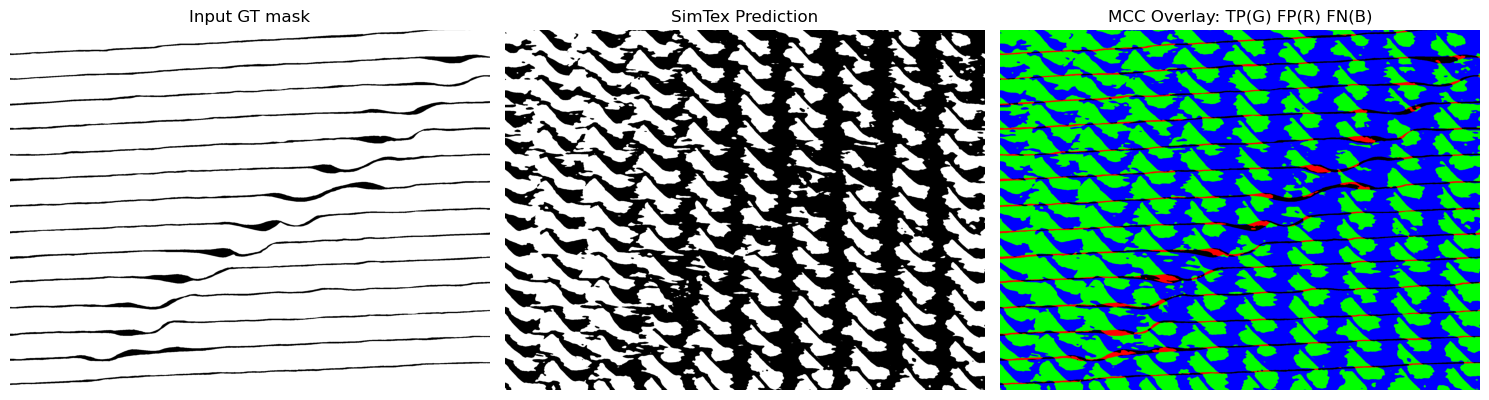

✅ Visual overlay complete


In [73]:
# Visualise TP, FP, FN overlays for CJM images
from matplotlib.colors import ListedColormap

# Pick one GT–Prediction pair with worst MCC (optional: try best later)
worst_gt_path = os.path.join(gt_dir, mcc_scores_cjm_sorted[-1][0])
worst_pred_path = os.path.join(pred_dir, pred_map[strip_suffix(mcc_scores_cjm_sorted[-1][0])])

# Load and process
gt_img = cv2.imread(worst_gt_path, cv2.IMREAD_GRAYSCALE)
pred_img = cv2.imread(worst_pred_path, cv2.IMREAD_GRAYSCALE)

# Resize prediction to GT size if needed
if gt_img.shape != pred_img.shape:
    pred_img = cv2.resize(pred_img, (gt_img.shape[1], gt_img.shape[0]), interpolation=cv2.INTER_NEAREST)

# Threshold
_, gt_bin = cv2.threshold(gt_img, 128, 255, cv2.THRESH_BINARY)
_, pred_bin = cv2.threshold(pred_img, 128, 255, cv2.THRESH_BINARY)

# Make TP/FP/FN masks
tp = np.logical_and(gt_bin == 255, pred_bin == 255)
fp = np.logical_and(gt_bin == 0, pred_bin == 255)
fn = np.logical_and(gt_bin == 255, pred_bin == 0)

# Create overlay
overlay = np.zeros((*gt_bin.shape, 3), dtype=np.uint8)
overlay[tp] = [0, 255, 0]     # Green for TP
overlay[fp] = [255, 0, 0]     # Red for FP
overlay[fn] = [0, 0, 255]     # Blue for FN

# Plot
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.title("Input GT mask")
plt.imshow(gt_bin, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("SimTex Prediction")
plt.imshow(pred_bin, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("MCC Overlay: TP(G) FP(R) FN(B)")
plt.imshow(overlay)
plt.axis('off')

plt.tight_layout()
plt.show()

print("✅ Visual overlay complete")

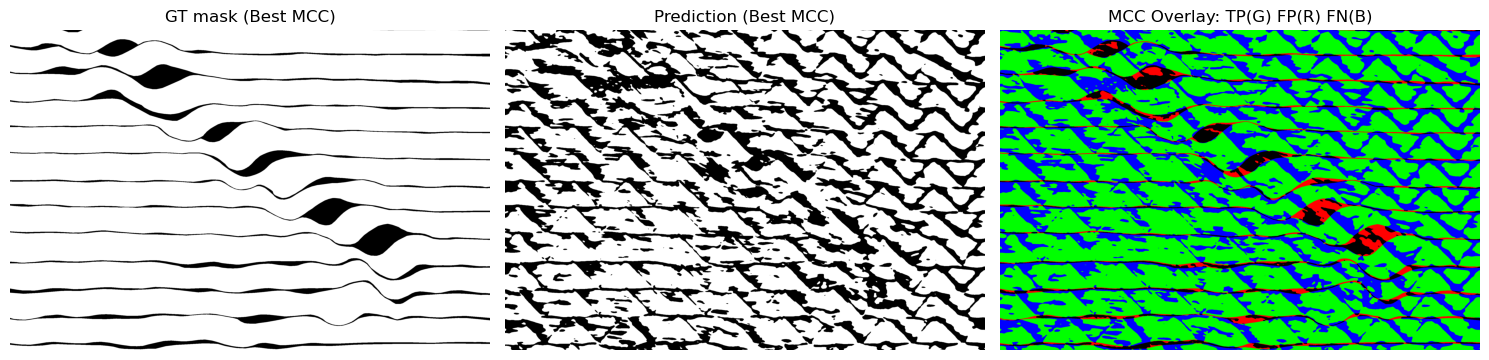

✅ Visual overlay for BEST MCC complete


In [75]:
# Visualise TP, FP, FN overlays for BEST CJM image
from matplotlib.colors import ListedColormap

# Pick GT–Prediction pair with best MCC
best_gt_path = os.path.join(gt_dir, mcc_scores_cjm_sorted[0][0])
best_pred_path = os.path.join(pred_dir, pred_map[strip_suffix(mcc_scores_cjm_sorted[0][0])])

# Load and process
gt_img = cv2.imread(best_gt_path, cv2.IMREAD_GRAYSCALE)
pred_img = cv2.imread(best_pred_path, cv2.IMREAD_GRAYSCALE)

# Resize prediction to GT size if needed
if gt_img.shape != pred_img.shape:
    pred_img = cv2.resize(pred_img, (gt_img.shape[1], gt_img.shape[0]), interpolation=cv2.INTER_NEAREST)

# Threshold
_, gt_bin = cv2.threshold(gt_img, 128, 255, cv2.THRESH_BINARY)
_, pred_bin = cv2.threshold(pred_img, 128, 255, cv2.THRESH_BINARY)

# Create TP/FP/FN masks
tp = np.logical_and(gt_bin == 255, pred_bin == 255)
fp = np.logical_and(gt_bin == 0, pred_bin == 255)
fn = np.logical_and(gt_bin == 255, pred_bin == 0)

# Create overlay image
overlay = np.zeros((*gt_bin.shape, 3), dtype=np.uint8)
overlay[tp] = [0, 255, 0]     # Green for TP
overlay[fp] = [255, 0, 0]     # Red for FP
overlay[fn] = [0, 0, 255]     # Blue for FN

# Plotting
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title("GT mask (Best MCC)")
plt.imshow(gt_bin, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Prediction (Best MCC)")
plt.imshow(pred_bin, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("MCC Overlay: TP(G) FP(R) FN(B)")
plt.imshow(overlay)
plt.axis('off')

plt.tight_layout()
plt.show()

print("✅ Visual overlay for BEST MCC complete")


/var/folders/t0/cg3zdgw11kbccwbtk4jlmvmh0000gn/T/ipykernel_57582/2487459991.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sorted_names, y=sorted_scores, palette="coolwarm", hue=None)


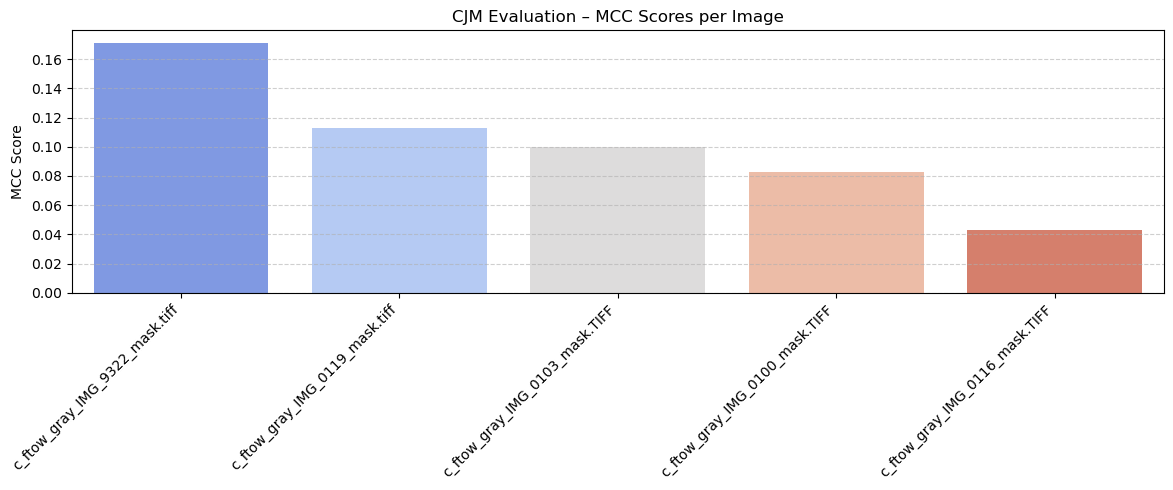

✅ Bar chart of MCC scores complete


In [81]:
# Bar chart of all MCC scores (CJM)
import seaborn as sns

# Sort scores (already sorted earlier)
sorted_names = [name for name, _ in mcc_scores_cjm_sorted]
sorted_scores = [score for _, score in mcc_scores_cjm_sorted]

# Plot
plt.figure(figsize=(12, 5))
sns.barplot(x=sorted_names, y=sorted_scores, palette="coolwarm", hue=None)

plt.xticks(rotation=45, ha='right')
plt.ylabel("MCC Score")
plt.title("CJM Evaluation – MCC Scores per Image")
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

print("✅ Bar chart of MCC scores complete")

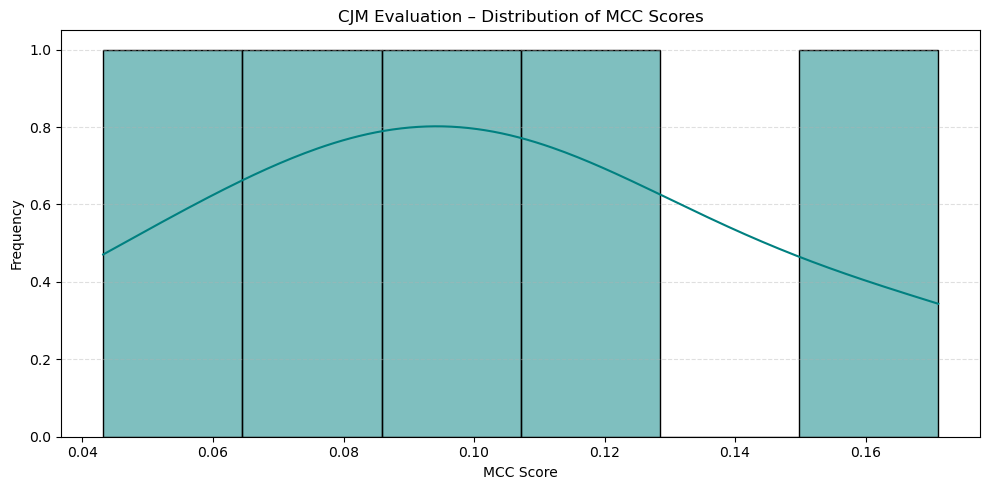

✅ Histogram + KDE of MCC scores (CJM) complete


In [85]:
# Histogram + KDE Curve of MCC Scores (CJM)
plt.figure(figsize=(10, 5))
sns.histplot(sorted_scores, bins=6, kde=True, color="teal", edgecolor='black')

plt.title("CJM Evaluation – Distribution of MCC Scores")
plt.xlabel("MCC Score")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

print("✅ Histogram + KDE of MCC scores (CJM) complete")